# Assignment 1 - Image Classification

This notebook contains the required task for the first assignment of the Deep Network Development course. Read the task description and fill in the empty code cells. Each section represents an implementation stage of an image classifier, from loading and inspecting the dataset to implementing and training a Convolutional Neural Network architecture. The sections guide you but you do not have to follow that specific order.

## Task description

Your task is to compare the performance of a given pre-trained model and a modified version of it, using a given dataset. The datasets contain images as input and class labels as target, thus you have to solve a Supervised Machine Learning Classification problem.

Steps
1. If your dataset has more than 5 classes, then select 5 classes of your choice (explain why). If your dataset has 5 or less classes, ignore this step.
2. The dataset should be split into train, validation and test sets. Some datasets already have these splits, otherwise, you can split the training set into validation and test sets.
3. Use the test set to do inference with the pre-trained model. Calculate the accuracy of the pre-trained model.
4. Modify the pre-trained model and train it with the train/validation sets. Modifying means removing/replacing/adding layers. We recommend changing the: head (you need to do this because the pre-trained models were created to predict 1000 classes from Imagenet, however, in your case, the number of classes is different, so you must change the head); backbone (remove/replace layers in the backbone. Be aware that once you do that, you need to be able to adjust the networks output dimensions by changing the properties like filter size, padding, etc)
5. Use the test set to do inference with the newly modified/trained model. Calculate the accuracy.
6. Compare the results from the pre-trained model and the modified version.
7. Explain the differences.
Please submit only the notebook to Canvas. (Do not upload the dataset nor the models)

There is no expected percentage of accuracy, but **your accuracy should be better than random guessing and your loss has to decrease throughout the epochs**. We expect you to show visualizations (matplotlib, seaborn, ...) of the accuracy, loss, and confusion matrix. Use Early stopping and save the best model while training your network.


There are some example questions at the end of the notebook.

## 0. Import libraries
Import all libraries/packages that you believe will help you fulfil the task, but **for the network only PyTorch can be used.**

In [ ]:
import torch
import torchvision #has various utils functions, including loading datasets
import torchvision.transforms as transforms #common image transformations
from torchvision import datasets, models
from torchsummary import summary

import torch.nn as nn #creating neural network https://pytorch.org/docs/stable/nn.html
import torch.nn.functional as F #functional api for layers,...
import torch.optim as optim #for optimization algorithm
import matplotlib.pyplot as plt #for visualization
import numpy as np #for basic array operations

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.model_selection import train_test_split
import seaborn as sns

#Set up GPU or CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## 1. Dataset
Load the dataset you were given. Images should be stored in an X variable and your labels in a Y variable. Split your dataset into train, validation and test set and pre-process your data for training.

#### Loading one example for each object type from the dataset
Show some images and labels of your dataset

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')
prefix = "/content/drive/My Drive/ELTE AI Master/DND/Assignment 1/"

ValueError: mount failed

In [ ]:
dataset_path = prefix + 'Data/indoorCVPR_09/Chosen Images'
batch_size = 16
image_width = 224
image_height = 224
image_size = (image_width, image_height)

# selected classes that are added to the chosen image folder so we won't have to load the whole data set and then split the chosen classes
selected_classes = ['airport_inside', 'children_room', 'grocerystore', 'inside_subway', 'kitchen']

# Define data transformations (you can customize this based on your needs)
transform = transforms.Compose([transforms.Resize(image_size), transforms.ToTensor()])

# Load the dataset
dataset = datasets.ImageFolder(dataset_path, transform = transform)

# Create a DataLoader for batch loading using the custom dataset
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
print(dataloader.dataset.classes)

['airport_inside', 'children_room', 'grocerystore', 'inside_subway', 'kitchen']


In [ ]:
# Define a function to display images
def show_images(images, labels, class_names):
    num_images = len(images)
    num_rows = 4
    num_cols = 4
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, 16))

    for i in range(num_rows):
        for j in range(num_cols):
            index = i * num_cols + j
            if index < num_images:
                image = images[index].numpy().transpose((1, 2, 0))
                label = labels[index].item()
                class_name = class_names[label]
                axes[i, j].imshow(image)
                axes[i, j].set_title(class_name)
                axes[i, j].axis('off')

    # Hide any remaining empty subplots
    for i in range(num_images, num_rows * num_cols):
        axes[i // num_cols, i % num_cols].axis('off')

    plt.tight_layout()

# Get a random batch from the DataLoader
data_iter = iter(dataloader)
images, labels = next(data_iter)

# Display the images and labels
show_images(images, labels, dataset.classes)
plt.show()

Output hidden; open in https://colab.research.google.com to view.

#### Splitting the dataset

In [ ]:
# Define the ratio for splitting (70% training, 15% validation, 15% test)
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Calculate the number of examples in each split
total_size = len(dataset)
train_size = int(train_ratio * total_size)
val_size = int(val_ratio * total_size)
test_size = total_size - train_size - val_size

# Create random samplers for the training, validation, and test sets
train_sampler = torch.utils.data.SubsetRandomSampler(range(train_size))
val_sampler = torch.utils.data.SubsetRandomSampler(range(train_size, train_size + val_size))
test_sampler = torch.utils.data.SubsetRandomSampler(range(train_size + val_size, total_size))

#### Pre-processing the dataset (data loader with transformations)

In [ ]:
# Define the data transformations
data_transforms = transforms.Compose([
    transforms.Resize(image_size),        # Resize the image to a consistent size
    transforms.RandomHorizontalFlip(),    # Randomly flip the image horizontally
    transforms.RandomVerticalFlip(),      # Randomly flip the image vertically
    transforms.RandomRotation(10),        # Randomly rotate the image by up to 10 degrees
    transforms.ToTensor(),                # Convert the image to a PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize image data
])

# Apply the transformations into the loaded dataset
dataset.transform = data_transforms

# Create DataLoaders for each set using the samplers
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=val_sampler)
test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=test_sampler)

In [ ]:
# Display images from train Loader to make sure the transformation were applied
data_iter = iter(train_loader)
images, labels = next(data_iter)
# show_images(images, labels, dataset.classes)
# plt.show()

#### Check the number of images and class balances in the  train, validation and test set

In [ ]:
from collections import defaultdict
def count_images_per_class(loader, dataset):
    class_counts = defaultdict(int)
    for data in loader:
        _, labels = data
        for label in labels:
            class_counts[label.item()] += 1

    class_names = dataset.classes
    total_images = sum(class_counts.values())

    return class_counts, class_names, total_images

def show_images_counts_dataset(loader, dataset, dataset_name):
    # Count the set loader
    class_counts, class_names, total_images = count_images_per_class(loader, dataset)

    # Print the results
    print("\n" + dataset_name + " Set:")
    print(f"Total Images: {total_images}")
    for name, count in zip(class_names, class_counts.values()):
        print(f"{name}: {count}")

In [ ]:
show_images_counts_dataset(train_loader, dataset, 'Train')
show_images_counts_dataset(val_loader, dataset, 'Validation')
show_images_counts_dataset(test_loader, dataset, 'Test')


Train Set:
Total Images: 1486
airport_inside: 112
children_room: 608
grocerystore: 457
inside_subway: 96
kitchen: 213

Validation Set:
Total Images: 318
airport_inside: 318

Test Set:
Total Images: 320
airport_inside: 320


In [ ]:
# Get the list of classes in the dataset
class_names = dataset.classes

# Initialize lists to hold datasets for each class
train_datasets = []
val_datasets = []
test_datasets = []

test_size = 0.15
val_size = 0.15

# Split the dataset by class
for class_name in class_names:
    class_indices = [idx for idx, (img, label) in enumerate(dataset) if label == class_names.index(class_name)]

    # Split the class samples into train, validation, and test sets
    train_indices, test_val_indices = train_test_split(class_indices, test_size=val_size + test_size, random_state=42)
    val_indices, test_indices = train_test_split(test_val_indices, test_size=test_size, random_state=42)

    # Create class-specific datasets for each split
    train_dataset = torch.utils.data.Subset(dataset, train_indices)
    val_dataset = torch.utils.data.Subset(dataset, val_indices)
    test_dataset = torch.utils.data.Subset(dataset, test_indices)

    # Append class-specific datasets to the corresponding lists
    train_datasets.append(train_dataset)
    val_datasets.append(val_dataset)
    test_datasets.append(test_dataset)

# Concatenate class-specific datasets to create final train, validation, and test datasets
train_dataset = torch.utils.data.ConcatDataset(train_datasets)
val_dataset = torch.utils.data.ConcatDataset(val_datasets)
test_dataset = torch.utils.data.ConcatDataset(test_datasets)

# Create DataLoaders for each set
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
show_images_counts_dataset(train_loader, dataset, 'Train')
show_images_counts_dataset(val_loader, dataset, 'Validation')
show_images_counts_dataset(test_loader, dataset, 'Test')


Train Set:
Total Images: 1484
airport_inside: 149
children_room: 513
grocerystore: 319
inside_subway: 425
kitchen: 78

Validation Set:
Total Images: 541
airport_inside: 155
children_room: 28
grocerystore: 54
inside_subway: 117
kitchen: 187

Test Set:
Total Images: 99
airport_inside: 28
children_room: 6
grocerystore: 10
inside_subway: 21
kitchen: 34


## 2. Convolutional Neural Network Architecture
Load the pre-trained CNN architecture you were given. Reduce the size of the given model by removing some layers and parameters with less influence. Define the optimizer and loss function. Train your network and save it. Remember to use Early stopping and show results.

#### Load the given pre-trained model

In [ ]:
model = models.resnet18(pretrained=True)
model.eval()
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 105MB/s]


#### Summary of the given pre-trained model

In [ ]:
input_size = (3, image_width, image_height)
summary(model, input_size=input_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

#### Predicting on the test data

In [ ]:
# Define a list to store predictions
predictions = []

# Perform inference on the test set
with torch.no_grad():
    for inputs, _ in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())

#### Showing the accuracy score of the pre-trained model

In [ ]:
true_labels = [true_label for _, true_label in test_dataset]  # True labels from the test dataset
accuracy = accuracy_score(true_labels, predictions)
print(f"Accuracy: {accuracy * 100:.2f}%") # 0% which is normal since the model is trained on a different dataset

Accuracy: 0.00%


#### Showing the confusion matrix for the pre-trained model

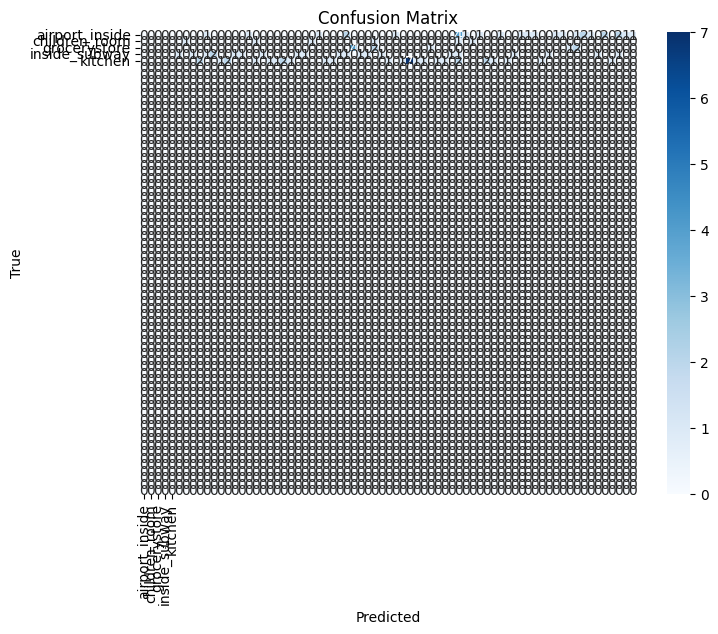

In [ ]:
# Although the matrix is gonna show unrealistic data since it is trained of different labels than the chosen labels from our dataset
# Compute the confusion matrix
conf_matrix = confusion_matrix(true_labels, predictions)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

#### Implement the new architecture with less parameter

In [ ]:
my_model = models.resnet18(pretrained=True)
my_model = my_model.to(device)
my_model.fc = nn.Linear(my_model.fc.in_features, len(class_names))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


#### Summary of the new architecture

In [ ]:
summary(my_model.to(device), input_size=input_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

## 3. Training

#### Define your loss function

In [ ]:
criterion = nn.CrossEntropyLoss()

#### Define your optimizer

In [ ]:
optimizer = torch.optim.SGD(my_model.parameters(), lr=0.001, momentum=0.9)

#### Train your network

In [ ]:
# Train the model
def train_model(model, train_loader, val_loader, num_epochs = 5):
    total_loss_h = []
    total_vloss_h = []
    model.train()
    model.to(device)
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}:')
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step() # updating the weights of the network

            # print statistics
            total_loss_h.append(np.array(loss.cpu().detach()))

            if i % 200 == 0:
                with torch.no_grad():
                    model.eval()
                    vloss=0
                    for iv, datav in enumerate(val_loader, 0):
                        inputs, labels = datav[0].to(device), datav[1].to(device)
                        outputs = model(inputs)
                        vloss = np.array(criterion(outputs, labels).cpu().detach())
                    print(f'Iteration {i}, loss = {(loss):.3f}, vloss = {(vloss):.3f}')
            total_vloss_h.append(vloss)
            model.train()

    print('Finished Training')
    return model, total_loss_h, total_vloss_h

# Plot the loss
def plot_loss(total_loss_h, total_vloss_h):
    plt.figure(figsize=(10,6))
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Loss by Iteration')

    plt.plot(total_loss_h)
    plt.plot(total_vloss_h)
    plt.legend(['train', 'valid'])
    plt.ylim((0,10))

# Show Accuracy
def show_accuracy(model, dataset_loader, dataset_name = 'dataset name'):
    correct = 0
    total = 0
    labels_total=[]
    prediction_total=[]
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in dataset_loader:
            images, labels = data
            # calculate outputs by running images through the network
            outputs = model(images.to(device))
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            predicted=predicted.cpu()
            labels_total=np.append(labels_total,labels.numpy(), axis=0)
            prediction_total=np.append(prediction_total,predicted.numpy(), axis=0)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the '+ dataset_name +' set: %d %%' % (
        100 * correct / total))
    return correct, total, labels_total, prediction_total

#### Show the loss on training and validation sets

Epoch 0:
Iteration 0, loss = 1.961, vloss = 1.905
Epoch 1:
Iteration 0, loss = 0.148, vloss = 0.120
Epoch 2:
Iteration 0, loss = 0.183, vloss = 0.101
Epoch 3:
Iteration 0, loss = 0.300, vloss = 0.067
Epoch 4:
Iteration 0, loss = 0.017, vloss = 0.030
Finished Training


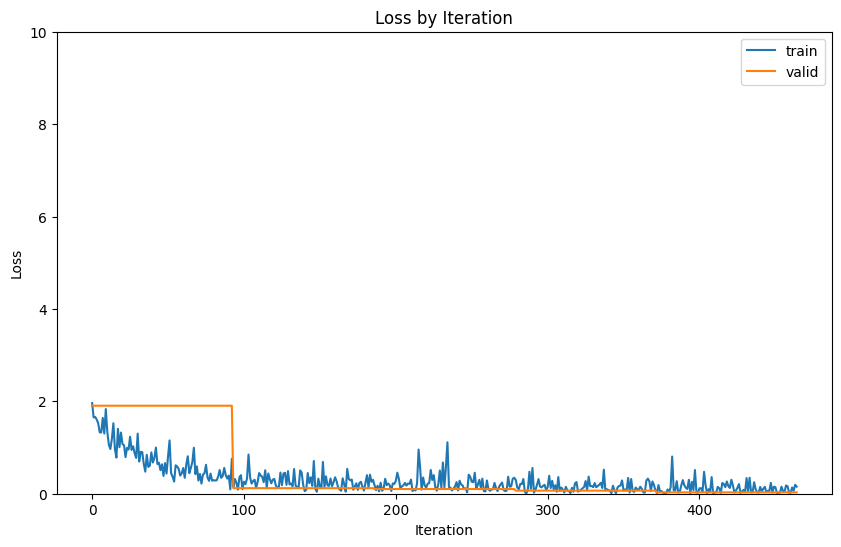

In [ ]:
my_model, total_loss_h, total_vloss_h = train_model(my_model, train_loader, val_loader, 5)
plot_loss(total_loss_h, total_vloss_h)

#### Show the accuracy on training and validation sets

In [ ]:
my_model.eval()
train_correct, train_total, train_labels_total, train_prediction_total = show_accuracy(my_model, train_loader, 'train')
val_correct, val_total, val_labels_total, val_prediction_total = show_accuracy(my_model, val_loader, 'validation')

Accuracy of the network on the train set: 99 %
Accuracy of the network on the validation set: 95 %


#### Save your trained CNN

In [ ]:
my_model_path = prefix + 'my_model.pth'
torch.save(my_model.state_dict(), my_model_path)

#### Loading the trained saved model

In [ ]:
# my_model = models.resnet18(pretrained=True)
# state_dict = torch.load(my_model_path)
# my_model.load_state_dict(state_dict)
# my_model.eval()

## 4. Evaluation and Testing
Load your trained CNN and evaluate it on the test set.
Show the confusion matrix on the test set.
Show some predictions on the test set (3 is enough) by plotting the image and printing the prediction and ground truth.
Show some missed predictions (3 is enough) and try to explain why it was difficult for the model to recognize these images.

#### Evaluate your model

In [ ]:
my_model.eval()
test_correct, test_total, test_labels_total, test_prediction_total = show_accuracy(my_model, test_loader, 'test')

Accuracy of the network on the test set: 95 %


#### Show the test accuracy next to the training and validation

In [ ]:
print('Accuracy of the network on the train set: %d %%' % (100 * train_correct / train_total))
print('Accuracy of the network on the validation set: %d %%' % (100 * val_correct / val_total))
print('Accuracy of the network on the test set: %d %%' % (100 * test_correct / test_total))

Accuracy of the network on the train set: 99 %
Accuracy of the network on the validation set: 95 %
Accuracy of the network on the test set: 95 %


#### Confusion matrix

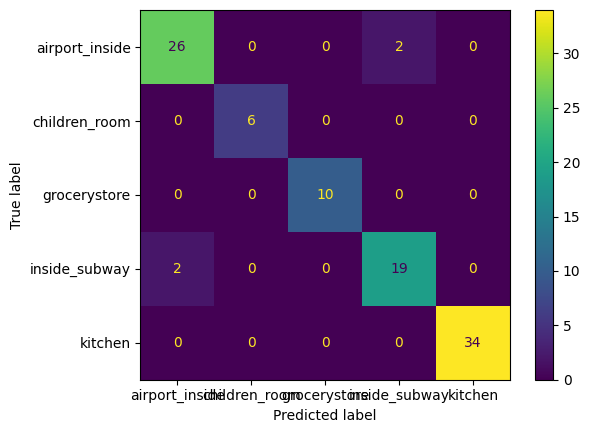

In [ ]:
cm=confusion_matrix(test_labels_total, test_prediction_total)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot()

#### Show some predictions

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

def visualize_model(model, dataloader, num_images=6, right_predictions = True):
    was_training = model.training
    model.eval()
    images_so_far = 0

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                original_label = class_names[labels[j]]
                predicted_label = class_names[preds[j]]
                if (right_predictions) and (original_label != predicted_label):
                  continue
                if (not right_predictions) and (original_label == predicted_label):
                  continue
                fig = plt.figure(figsize=(10,10))
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                original_label = class_names[labels[j]]
                predicted_label = class_names[preds[j]]
                ax.set_title(f'Predicted: {predicted_label}\nOriginal: {original_label}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

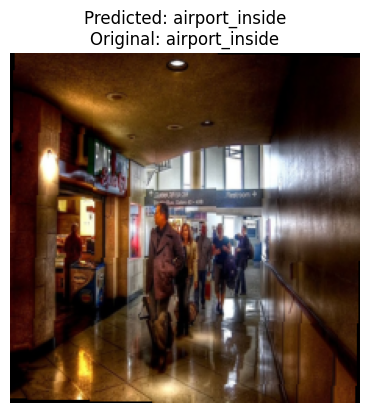

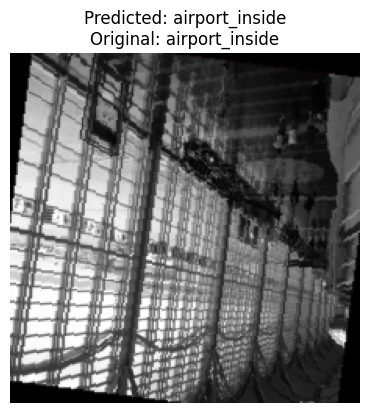

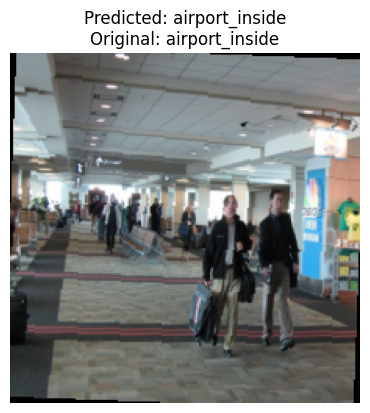

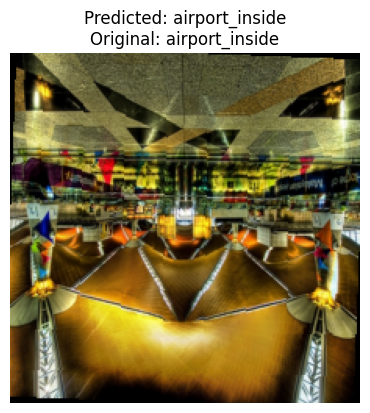

In [ ]:
visualize_model(my_model, val_loader, 4, True)

#### Missed predictions

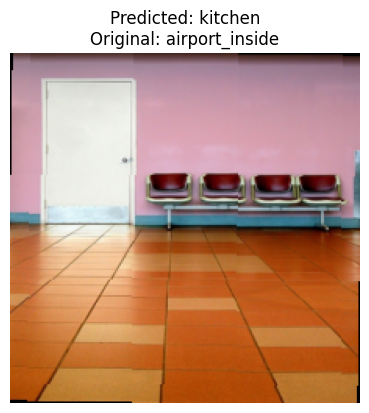

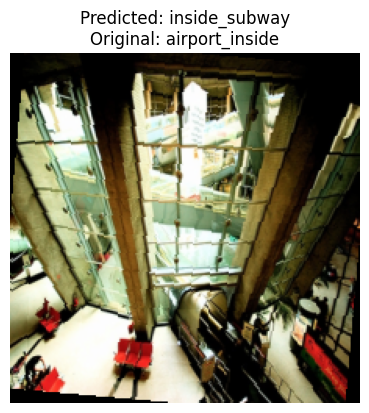

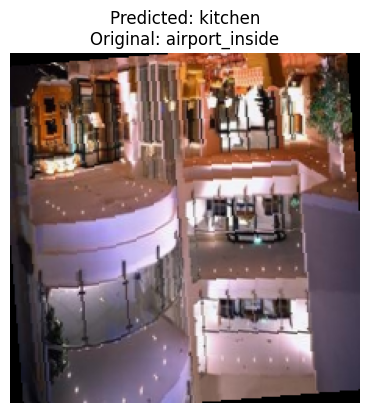

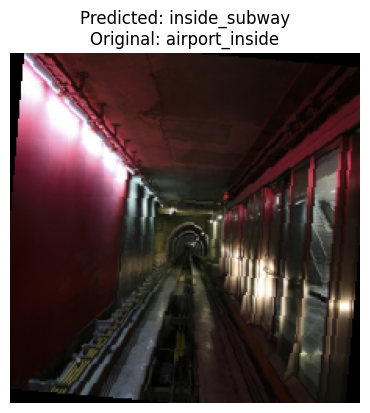

In [ ]:
visualize_model(my_model, val_loader, 4, False)

#### Backbone Edits

In [ ]:
backbone_model_path = prefix + 'backbone_model.pth'
backbone_model = models.resnet18(pretrained=True)
backbone_model = backbone_model.to(device)
backbone_model.fc = nn.Linear(backbone_model.fc.in_features, len(class_names))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Defining new model layers (Basic Blocks)
first_sequential = nn.Sequential(
      nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False),
      nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
      nn.ReLU(inplace=True),
      nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=False),
      nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True))

second_sequential = nn.Sequential(
      nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1, bias=False),
      nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
      nn.ReLU(inplace=True),
      nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1, bias=False),
      nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True))

In [ ]:
summary(backbone_model.to(device), input_size=input_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

#### Editing the first two layer of the ResNet (Removing 20 layers)

In [ ]:
# Editing the layers of the model
backbone_model.layer1 = first_sequential
backbone_model.layer2 = second_sequential

In [ ]:
summary(backbone_model.to(device), input_size=input_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
           Conv2d-10          [-1, 128, 28, 28]          73,728
      BatchNorm2d-11          [-1, 128, 28, 28]             256
             ReLU-12          [-1, 128, 28, 28]               0
           Conv2d-13          [-1, 128, 28, 28]         147,456
      BatchNorm2d-14          [-1, 128,

Epoch 0:
Iteration 0, loss = 1.821, vloss = 1.125
Epoch 1:
Iteration 0, loss = 1.729, vloss = 1.520
Epoch 2:
Iteration 0, loss = 1.706, vloss = 1.378
Epoch 3:
Iteration 0, loss = 1.539, vloss = 1.539
Epoch 4:
Iteration 0, loss = 1.335, vloss = 1.522
Epoch 5:
Iteration 0, loss = 1.520, vloss = 1.495
Epoch 6:
Iteration 0, loss = 1.815, vloss = 1.506
Epoch 7:
Iteration 0, loss = 1.741, vloss = 1.430
Epoch 8:
Iteration 0, loss = 1.926, vloss = 1.514
Epoch 9:
Iteration 0, loss = 1.799, vloss = 1.522
Epoch 10:
Iteration 0, loss = 1.731, vloss = 1.506
Epoch 11:
Iteration 0, loss = 1.971, vloss = 1.630
Epoch 12:
Iteration 0, loss = 1.613, vloss = 1.480
Epoch 13:
Iteration 0, loss = 1.749, vloss = 1.552
Epoch 14:
Iteration 0, loss = 1.757, vloss = 1.487
Epoch 15:
Iteration 0, loss = 1.632, vloss = 1.498
Epoch 16:
Iteration 0, loss = 1.725, vloss = 1.533
Epoch 17:
Iteration 0, loss = 1.707, vloss = 1.436
Epoch 18:
Iteration 0, loss = 1.534, vloss = 1.412
Epoch 19:
Iteration 0, loss = 1.688, vlos

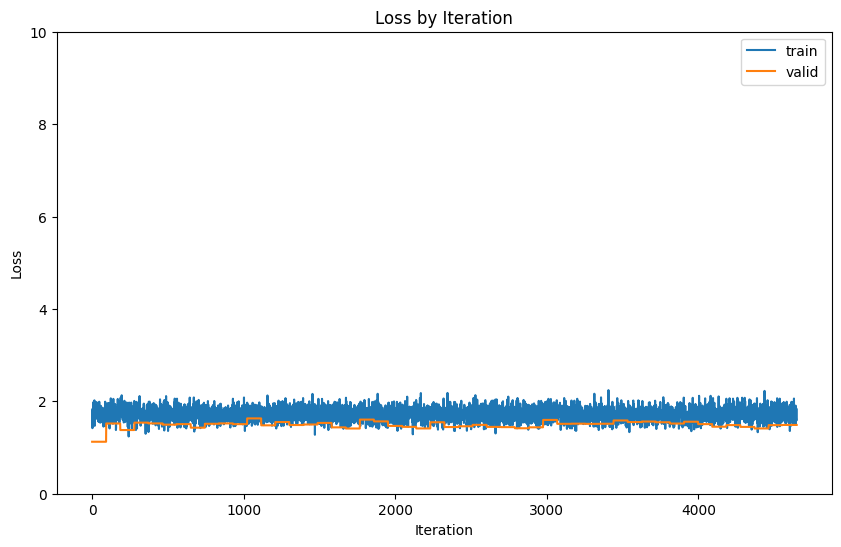

In [ ]:
backbone_model, backbone_total_loss_h, backbone_total_vloss_h = train_model(backbone_model, train_loader, val_loader, 50)
plot_loss(backbone_total_loss_h, backbone_total_vloss_h)

In [ ]:
backbone_model.eval()
train_correct, train_total, train_labels_total, train_prediction_total = show_accuracy(backbone_model, train_loader, 'train')
val_correct, val_total, val_labels_total, val_prediction_total = show_accuracy(backbone_model, val_loader, 'validation')
test_correct, test_total, test_labels_total, test_prediction_total = show_accuracy(backbone_model, test_loader, 'test')

Accuracy of the network on the train set: 21 %
Accuracy of the network on the validation set: 19 %
Accuracy of the network on the test set: 28 %


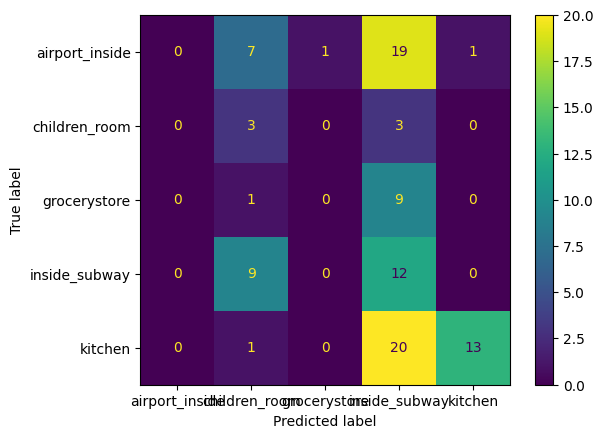

In [ ]:
cm=confusion_matrix(test_labels_total, test_prediction_total)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot()

In [ ]:
torch.save(backbone_model.state_dict(), backbone_model_path)

## 5. Some example questions that help you prepare for the defense

## Answering The Questions
* Data
    - Describe your dataset.  
      The dataset is a set of images and rooms of different scenes in different places. There were multiple classes in the given dataset (67 classes), and only five were chosen, the chosen classes were chosen depending on how different they were from each other (characteristic wise), and how much samples are there for each class (The highest number of training samples)

    - List augmentation techniques.  
      1- Resizing the image to the default size that most models use and to make all of them the same size.  
      2- Horizontally flipping the image so we could create more variations to the training data.  
      3- Vertically Flipping  
      4- Random Rotation up to 10 degrees  
      5- Normalization, by subtracting the provided mean from the images on the three different channels and then divinding by the standard deviation. These valus were taken from the ImageNet datset which was proved to be good as a starting point to train the model on these images

    - Normalization standardization why do we use them?  
      The purpose of normalization is to make sure that the pixel values in the input images have a consistent scale, and to make it easier for the neural network to learng during the training.

* Model
    - Describe the model and its parameters (Convolutional Layer, Pooling Layer, flatten, concatenation, activation, linear, argmax).  
      **Convolutional layer:** The point of the convolutional layer is applying some filters to extract the wanted featrues from the images so it would help the neural network learn more about the images and classify more accuratly.  
      **Activation:** The activation helps to threshholds the output from the training layer and helps with the non-linearity so the model would fit better.  
      **Pooling layer:** The main poing of using them is for the dimension reduction, so we won't have to make a lot of computation on the images.  
      **Flatten:** After using multiple conv layers and pooling layers to extract the features and resuce the dimensions, we will flatten the image into a vector to deal with it in the fully connected layer. (it is used as an input for the fully connected layers)  
      **Linear:** The linear is where the fully connected neural network is, and where we deal with the number of neurons to show our prediction (output).  

    - How can we change the output dimension? What happens if we change the head or the backbone? (filter number or replace them,...).  
      we have to be carefule while editing on the head or the backbone since we have o match the dimension with the previous layer, and since this is a classification problem we have to let the head be the same number as the classes we have, we can change on the backbone while maintaing the dimension and it might help the model to recognise other objects in the images or put more imphasis on different things.

* Optimizer
    - Describe the optimizer. What parameters does it have? (some connection to the date, model, and loss function)  
    bold text
    The optimizer is responsible for the editing of the wieghts and biases in the neural network since it contains the learning rate which affects how fast the model is learning and the momentum which helps with the precision of the weights editing by using values from previous gradients and helping to escape from the local minima.

* Loss function and regularisation
    - Describe the loss functions and some regularization methods.  

    The Cross-Entropy Loss function is mostly used in the classification problems because it measures the difference between the predicted class and the actual class that is wanted to get. (In probabilities)

* Results  
    - Describe the results based on overfitting, underfitting, bias, and variance.  
    The results for the model without modifying the backbone were reasonable since, there were no over fitting since the accuracy was high for the train, and test sets.

    - Does the trained model complete the given task? What is the baseline for classification?  
    When we only changed the head the acc of the trained model was above 95% which means it's giving us good results, but when changing the layers in the backbone and delting from them, they should be done with deep understanding to what we are doing and how it would affect them, so we'll get different results.

    - Then the data balance, if it were unbalanced how would they deal with it?  
    Maybe we could generate new images from the less classes my applying different transforms on the images of the class, or we could filter the data so we would have an equal amount of images within all classes.

    - What other aspects can cause biased output? What simple methods do we have to unbias the model?  
    The variaty of the dataset which will make the model bias towards one class and not the other, maybe under representing a group of classes in the dataset would affect the result. we can elemenate the bias be checking the collected data to be representitive of all the classes that we want to classify.

    - Try to explain why it was difficult for the model to recognize the missed predictions.  
    The charachteristics of the wrongly predicted images looks kinda the same as the characterstics of the predection, so the inner subway and the inner airport scenes have kind of similar characteristics.

    - How can we improve the model?  
    Maybe if we edited more on the hyperparameters it will enhance the performance of the model, we could provide a larger dataset so we could enhance the results of the model, maybe if we tried different optimization methods we would be able to get different results.
